In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import timeit
from models import *
import seaborn as sns
import os

## First look at the data

In [2]:
#Dictionnaire de correspondance des passband et des targets
passband_list = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}
target_dict={90:'SNIa',67:'SNIa-91bg',
             52:'SNIax',42:'SNII',
             62:'SNIbc',95:'SLSN-I',
             15:'TDE',64:'KN',
             88:'AGN',92:'RRL',
             65:'M-dwarf',16:'EB',
             53:'Mira',6:'Lens-Single',
             994:'PISN', 999:'UNKNOWN'}

In [20]:
sample = 'Iron/'
curve = 'Half/'
PISN_split = '-2'
model = '_poly'
purpose = 'test'
file = 'f2'#FUSED
extras = '+4'

In [14]:
# this cannot be run without the filtered_dataDB_complete.pkl file

data = pd.read_pickle("../../plasticc/CleanDataBase/"+sample+curve+purpose+PISN_split+file+".pkl")
peaktable = pd.read_pickle('../../plasticc/CleanDataBase/'+sample+curve+purpose+PISN_split+file+'_maxdf.pkl').rename(columns = {0 :'max'})
data = pd.merge(peaktable, data, on=["object_id","passband"])

objects = np.unique(data['object_id'])
target_types = np.hstack([np.unique(data['target'])])
data

,object_id,passband,max,mjd,flux,flux_err,detected_bool,target
0,10001832,2,13.781970,0.0000,-0.522784,0.284707,0,90
1,10001832,2,13.781970,214.2541,1.000000,0.164775,1,90
2,10001832,2,13.781970,244.1777,0.054199,0.270519,0,90
3,10001832,2,13.781970,271.2205,-0.453759,0.346527,0,90
4,10001832,2,13.781970,326.0527,0.620562,0.378400,0,90
...,...,...,...,...,...,...,...,...
3358926,139524152,5,96.061089,300.9182,0.485999,0.343616,0,90
3358927,139524152,5,96.061089,302.9087,0.719593,0.502690,0,90
3358928,139524152,5,96.061089,318.9096,0.039494,0.463764,0,90
3358929,139524152,5,96.061089,355.0443,0.557194,0.194407,0,90


Text(0, 0.5, 'Number of objects')

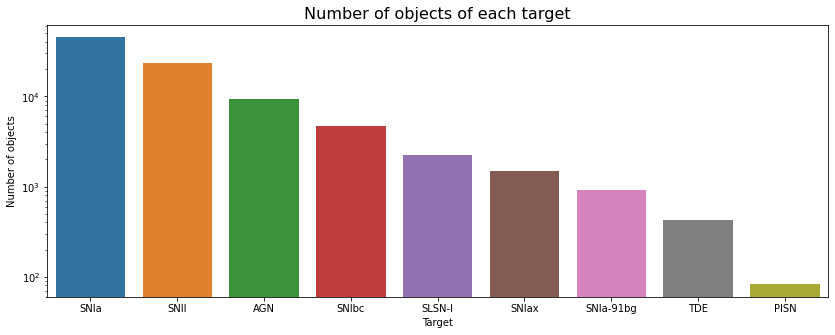

In [16]:
plt.figure(figsize=(14,5))

obj_per_target = []
for i in target_types :
    obj_per_target.append(len(np.unique(data.loc[data['target']==i, 'object_id'])))

    
sorted_target = [x for _, x in sorted(zip(obj_per_target, target_types),reverse=True)]
obj_per_target.sort(reverse=True)

for i in range (len(sorted_target)):
    sorted_target[i]=target_dict.get(sorted_target[i])

a = sns.barplot(x = sorted_target,y = obj_per_target)
a.set_yscale("log")

plt.title("Number of objects of each target",fontsize=16)
plt.xlabel('Target')
plt.ylabel('Number of objects')

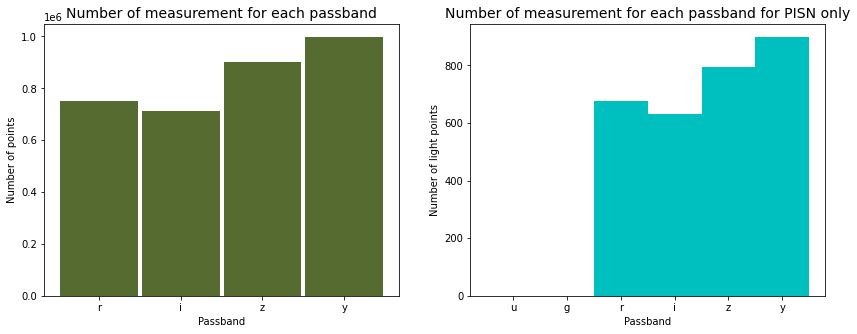

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title('Number of measurement for each passband',fontsize=14)
plt.hist(data['passband'],bins=[2,3,4,5,6],color='darkolivegreen',rwidth=0.95)
plt.ylabel('Number of points')
plt.xlabel('Passband')
plt.xticks(np.arange(4)+2.5, ['r','i','z','y']);

plt.subplot(1,2,2)
plt.title('Number of measurement for each passband for PISN only',fontsize=14)
plt.hist(data.loc[data['target']==994,'passband'],bins=[0,1,2,3,4,5,6],color='c')
plt.ylabel('Number of light points')
plt.xlabel('Passband')
plt.xticks(np.arange(6)+0.5, ['u','g','r','i','z','y']);

## Define useful functions

In [18]:
def compare(ide,band,table,model,nb_param,extra,band_used,norm=True):

    obj = data.loc[(data['object_id']==ide) & (data['passband']==band)]
    flux = np.array(obj['flux'])
    time = np.array(obj['mjd'])
    
    if norm == False :
        maxi = np.array(obj['max'])[0]
    else :
        maxi = 1
    
    
    fluxerr = np.array(obj['flux_err'])
    obj_target = np.array(data[data['object_id']==ide]['target'])[0]
    
    if len(time)<nb_param:
        print('Not enough points for object',ide,'in band',band)
        
    else :
        # Let's fit the data as a scatter
        plt.errorbar(time,flux*maxi,yerr=fluxerr,label="data band %s"%(band),fmt='o')
        plt.title('Object n°%s : %s'%(ide,target_dict.get(obj_target)))
        plt.xlabel('Time')
        plt.ylabel('Flux')

        #And the prediction
        x = np.linspace(time.min(),time.max(),200)

        a = (band - band_used.min()) * (nb_param + extra)
        b = (band - band_used.min()) * (nb_param + extra) + 1
        c = (band - band_used.min()) * (nb_param + extra) + 2

        obj_para=np.array(param_table.loc[param_table['object_id']==ide,[a, b, c]])[0]*maxi
        plt.plot(x,model(x,*obj_para),label='fit band %s'%(band),color='red')
        plt.legend()
        
def get_target(ide):
    return data.loc[data['object_id']==ide,'target'].min()

## Import a parameter table and plot it

In [21]:
param_table = pd.read_pickle("../../plasticc/param_table/"+sample+curve+big+purpose+PISN_split+model+extras+file+".pkl")
pltmodel = poly
band_used = np.array([2,3,4,5])
nb_param = 3
extra = 4 

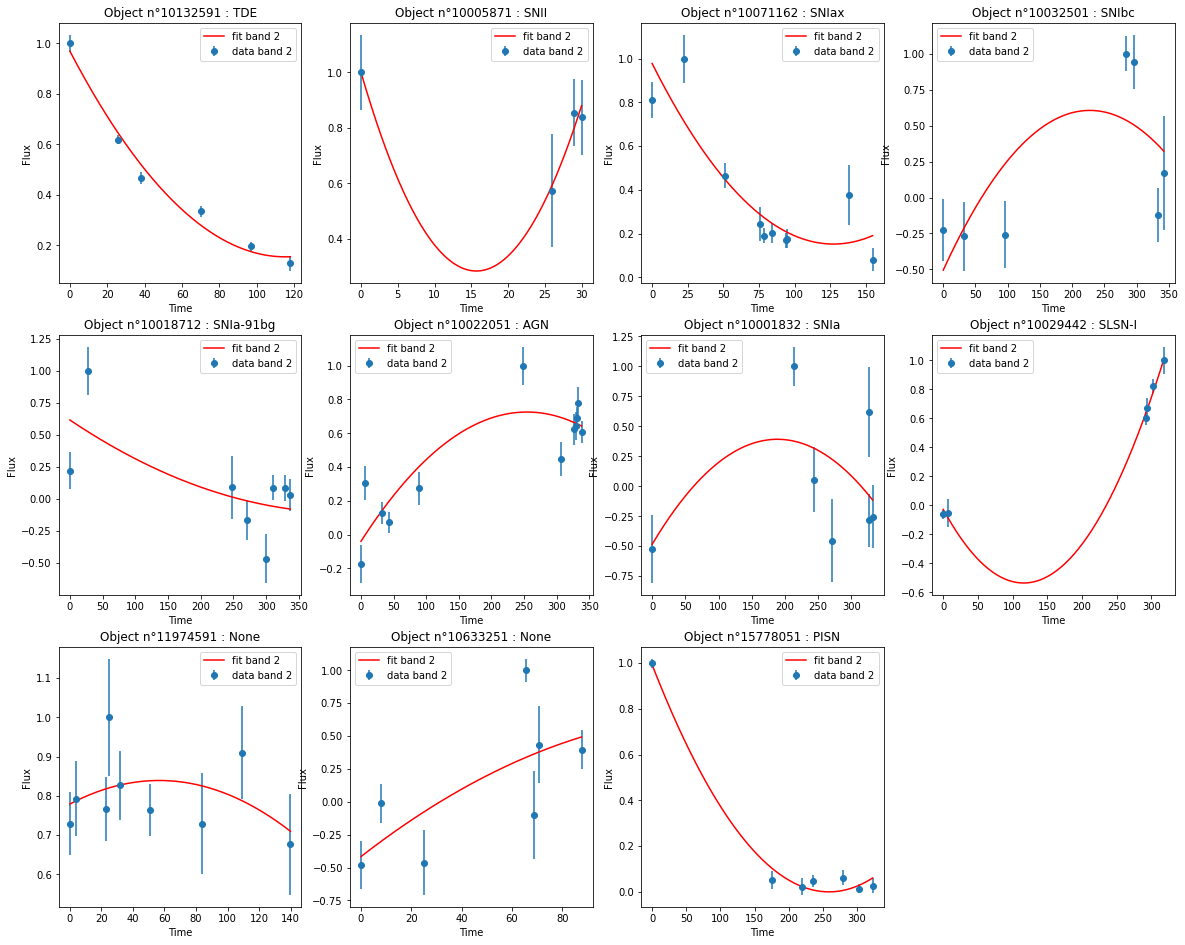

In [23]:
# Now let's use this function to see how well each object is fited

plt.figure(figsize=(20,22))

a=0
for i in target_types:
    a+=1
    subsample = data[data['target']==i]
    if len(subsample)>0:
        obj=subsample['object_id'].iloc[0] 
        plt.subplot(4,4,a)
        compare(obj,2,param_table,pltmodel,nb_param,extra,band_used)

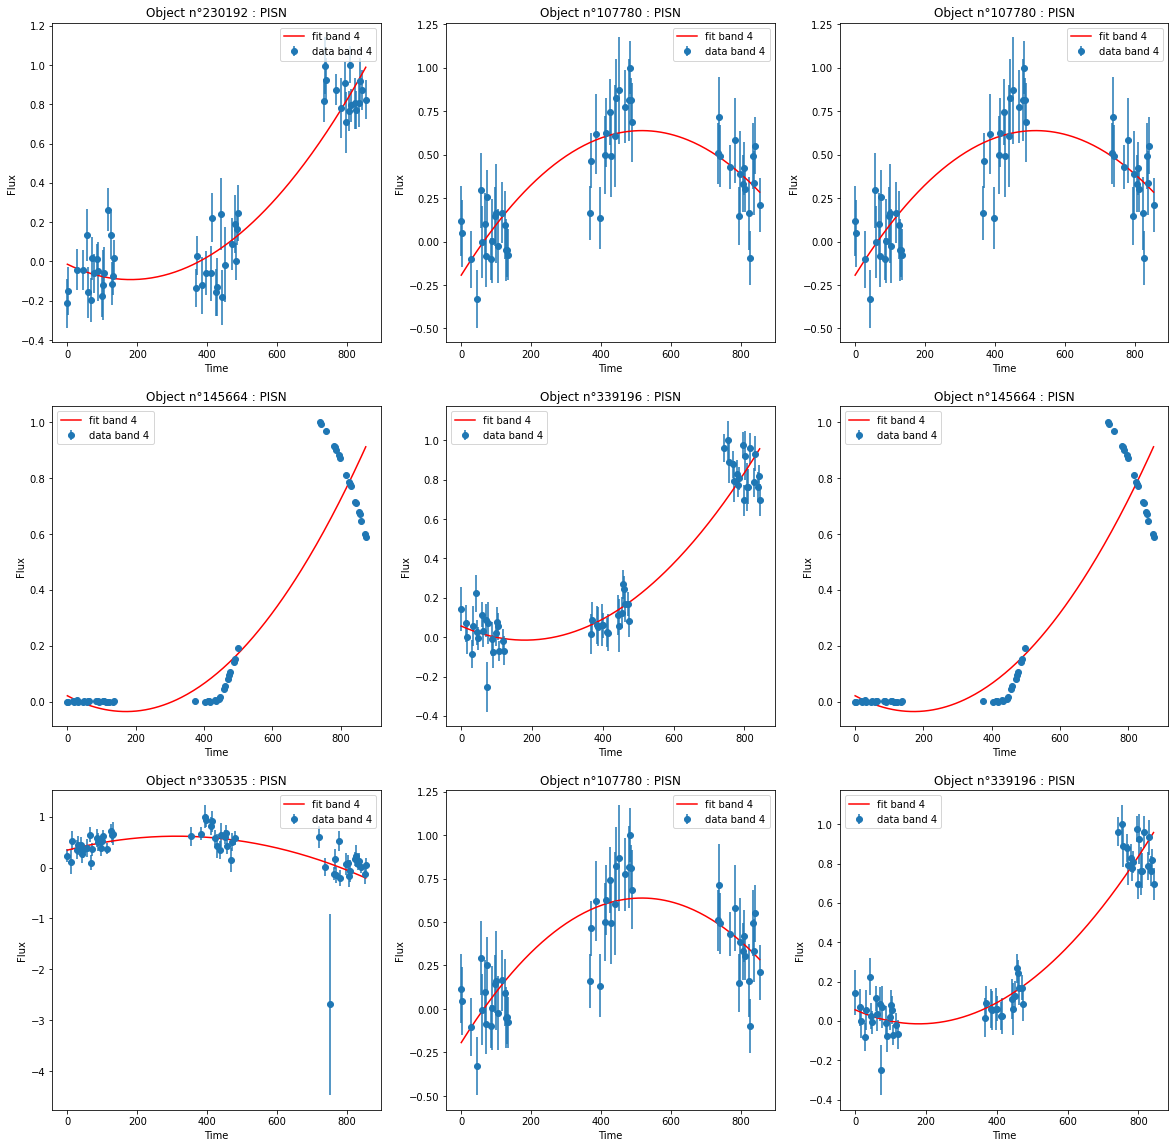

In [15]:
# Now let's use this function to see how well PISN are fitted
       
plt.figure(figsize=(20,20))
ids_type = np.unique(data.loc[data['target']==994,'object_id'])

for i in range(9):
    obj=np.random.choice(ids_type)
    obj_target= np.array(data[data['object_id']==obj]['target'])[0]
    plt.subplot(3,3,i+1)
    compare(obj,4,param_table,pltmodel,nb_param,extra,band_used)